In [45]:
import re
from functools import reduce
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Pre-Processing

In [2]:
batch_size = 300
vocab_size = 20000

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df['sentiment'] = (df['sentiment'] == 'positive').astype(int)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [4]:
print(f"average word count: {np.mean(df['review'].apply(lambda x: len(x.split())))}")

average word count: 231.15694


In [5]:
# clean a string and get the vocab words from it
def get_words(string):
    string = string.lower().replace('<br />', ' ') # <br /> tags frequently appear, remove them
    return re.findall(r'[a-z]+', string)

# create and clean the vocabulary
text_corpus = ' '.join(df['review'])
words = get_words(text_corpus)

# take the x most common words, otherwise we get a vocab of 100000
word_counts = Counter(words)
words = sorted(word_counts.items(), reverse=True, key=lambda x: x[1])[:vocab_size-5]
words = list(list(zip(*words))[0]) # remove the counts
words = ['<UNK>', '<PAD>', '<START>', '<END>', '<MASK>'] + words # add the tokens

In [6]:
# create the dictionaries to store the vocab
vocab_idx = {}
idx_vocab = {}
for i, word in enumerate(words):
    if word not in vocab_idx:
        vocab_idx[word] = i
        idx_vocab[i] = word
print(f"number of unique words: {len(vocab_idx)}")

number of unique words: 20000


In [7]:
# convert a string to a list of indexes of its words
# also add start and end tokens along with left padding
def string_to_idxs(string):
    idxs = list(map(lambda x: vocab_idx[x] if x in vocab_idx else 0, get_words(string)))
    idxs = [2] + idxs[-(batch_size-2):] + [3] # crop to the batch_size and add the start and end tokens
    padding = np.zeros((batch_size - len(idxs))) + 1
    idxs = np.concatenate([padding, idxs]).astype(int)
    return idxs

In [8]:
def index_to_string(idxes):
    return ' '.join(list(map(lambda x: idx_vocab[x], idxes)))

In [9]:
# create a column that represents reviews a list of the words' indexes in the vocab
df['idxed_review'] = df['review'].apply(string_to_idxs)
df['idxed_review']

0        [2, 33, 3177, 36, 29, 208, 18, 14, 10, 617, 51...
1        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
2        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
                               ...                        
49995    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
49996    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
49997    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
49998    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
49999    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: idxed_review, Length: 50000, dtype: object

#### Build training and test set
Training set has no closures and is a language modelling task

Test set has the closures and is a classification task

In [10]:
# turn the review column into a multi dimensional array
review_array = np.concatenate(df['idxed_review']).reshape(df.shape[0], batch_size)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(review_array, np.array(df['sentiment']), test_size=0.1)

In [12]:
# the label for each word is the next word in the seqeunce, we also add a pad token at the end to keep the dimensions the same
y_train = np.concatenate([X_train[:, 1:], np.ones((X_train.shape[0], 1)).astype(int)], axis=1)
y_train

array([[   1,    1,    1, ...,   16,    3,    1],
       [   1,    1,    1, ...,   11,    3,    1],
       [   7,  174,   54, ...,  300,    3,    1],
       ...,
       [   1,    1,    1, ..., 1703,    3,    1],
       [ 102,  119,   24, ...,  120,    3,    1],
       [ 240,  323,   26, ...,   59,    3,    1]])

In [13]:
X_train

array([[   1,    1,    1, ...,  404,   16,    3],
       [   1,    1,    1, ...,  107,   11,    3],
       [   2,    7,  174, ...,    6,  300,    3],
       ...,
       [   1,    1,    1, ...,    6, 1703,    3],
       [   2,  102,  119, ...,   26,  120,    3],
       [   2,  240,  323, ...,   72,   59,    3]])

### Model Building
- First train an LSTM as a language model, then have it solve closures to get the predictions
- Because the data would be too large to fit in memory if we converted it to one hot, we have to instead train using a generator (takes integers representing words and outputs a one hot vector
- Clozure to start with: "X + Overall this movie was (poor/great)"  (figure out how to do Bidirectional LSTM without it just predicting \<MASK\> later)

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout
tf.config.list_physical_devices('GPU') # check gpu is in use

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
# Create the generator class, it yields one review and its labels at a time
class SampleSequence(tf.keras.utils.Sequence): # extend Seqeunce so that we can use multiprocessing
    def __init__(self, X_train):
        self.X = X_train
        
    def __len__(self):
        return self.X.shape[0]
        
    # get item at the index specified
    def __getitem__(self, idx):
        # the pad_token is used for creating the labels
        pad_token = np.zeros((1, vocab_size))
        pad_token[0, 1] = 1
        
        x_sample = self.X[idx, :].reshape(1, batch_size) # the embedding layer automatically handles integers
        y_sample = np.zeros((batch_size, vocab_size)) # the labels need to be manually converted to one hot
        for i in range(batch_size - 1):
            y_sample[i, self.X[idx, i+1]] = 1  # the label at step1 is the word at step2
        y_sample[-1, :] = pad_token # add the pad token for the 300th step's label
        y_sample = y_sample.reshape(1, batch_size, vocab_size)
            
        return (x_sample, y_sample)

In [17]:
# Do the same thing but with a tensorflow dataset implementation, this allows parralelization 
# first define the mapping function to convert a tensor of X_train into an X, y sample
pad_token = np.zeros((1, vocab_size))
pad_token[0, 1] = 1
pad_token = tf.constant(pad_token, dtype='float32')
def text_to_sample(x_tensor): # takes a single sample and converts it to input text and ouput labels
    y_one_hot = tf.one_hot(x_tensor, vocab_size, axis=-1) # axos=-1 means we get a tensor of shape (features, vocab_size)
    y_one_hot = y_one_hot[1:, :] # shift back one
    y_one_hot = tf.concat([y_one_hot, pad_token], axis=0) # add pad token at the end 
    x_tensor = tf.reshape(x_tensor, [1, batch_size])
    return (x_tensor, y_one_hot)

# create training Dataset, apply the function to create the pipeline
def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(text_to_sample)
    return dataset

training = create_dataset(X_train)
testing = create_dataset(X_test)

In [ ]:
# Create the model, eventually this should be bi-directional
model = Sequential()
model.add(Embedding(vocab_size, 500, input_length=batch_size))
model.add(LSTM(500, return_sequences=True,
              activation='tanh', recurrent_activation='sigmoid',
              dropout=0.2, recurrent_dropout=0))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(20000, activation='softmax')))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
model.summary()

In [17]:
# With CUDNN implementation it runs faster, does take a lot of time to begin though
history = model.fit(x=training, validation_data=testing, epochs=10, 
                    use_multiprocessing=True, # allows multiple cpu cores to work on generating data samples at once
                    max_queue_size=50, # size of the queue of training items the cpu will create
                    workers=4) # number of processes that will generate items

Train for 45000 steps, validate for 5000 steps
Epoch 1/10
45000/45000 [==============================] - 3875s 86ms/step - loss: 3.7736 - categorical_accuracy: 0.4407 - val_loss: 3.5183 - val_categorical_accuracy: 0.4589
Epoch 2/10
45000/45000 [==============================] - 3199s 71ms/step - loss: 3.4452 - categorical_accuracy: 0.4652 - val_loss: 3.3598 - val_categorical_accuracy: 0.4714
Epoch 3/10
45000/45000 [==============================] - 3202s 71ms/step - loss: 3.3348 - categorical_accuracy: 0.4737 - val_loss: 3.2772 - val_categorical_accuracy: 0.4782
Epoch 4/10
45000/45000 [==============================] - 3199s 71ms/step - loss: 3.2688 - categorical_accuracy: 0.4790 - val_loss: 3.2256 - val_categorical_accuracy: 0.4826
Epoch 5/10
45000/45000 [==============================] - 3223s 72ms/step - loss: 3.2247 - categorical_accuracy: 0.4825 - val_loss: 3.1918 - val_categorical_accuracy: 0.4853
Epoch 6/10
45000/45000 [==============================] - 3314s 74ms/step - loss: 3

In [56]:
model.save("language_model.h5")

In [18]:
model = tf.keras.models.load_model("language_model.h5")

In [19]:
preds = model.predict(create_dataset(X_test[:100]))

In [20]:
labels = X_test[:1000, 1:300]

In [21]:
item = 2
index_to_string(X_test[item])

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

In [22]:
index_to_string(np.argmax(preds[item], axis=1))

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

In [23]:
np.flip(np.argsort(preds[50, 100]))[:20]

array([21,  6,  5, 12,  9, 26, 11,  7, 43, 20, 22, 14, 18, 15, 36, 13, 10,
       51, 32, 24], dtype=int64)

### Closure Creation 
Analyse performance on the test set given by solving closure problems

In [24]:
closures = np.zeros(X_test.shape, dtype='int')
prompt = "Overall the movie was"
for i in range(X_test.shape[0]):
    review = index_to_string(X_test[i, :-1]).replace('<PAD> ', '') # convert to string, removing the <END> and <PAD> tokens
    closures[i, :] = string_to_idxs(review + " " + prompt)
closures = create_dataset(closures)

In [37]:
# we need to perform prediction in steps as otherwise the output doesn't fit in memory
def generator_predict(closures):
    for data in closures:
        yield model.predict(data)[0, -1, :] # take the prediction for the last word

In [53]:
# calculate the predicted probabilities
pred_probas = [] # the probability that the next word is "Good" if it must by Good or Bad
for i, pred in enumerate(generator_predict(closures)):
    good_prob = pred[vocab_idx['good']] # great
    bad_prob = pred[vocab_idx['bad']]   # poor
    total = good_prob + bad_prob
    pred_probas.append(good_prob/(good_prob + bad_prob)) 

In [54]:
# Find the cutoff that gives the highest accuracy
pred_probas = np.array(pred_probas)
c_range = np.arange(0, 1, 0.001)
accuracies = []
for cutoff in c_range:
    class_preds = (pred_probas > cutoff).astype(int)
    accuracies.append(accuracy_score(y_test, class_preds))

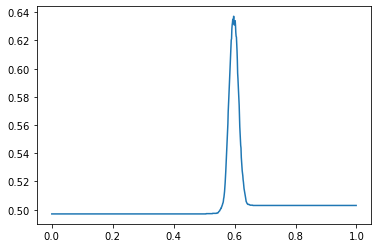

In [55]:
plt.plot(c_range, accuracies)